# Packages

In [18]:
!pip install lime
# basic packages
from time import time

# basic data processing packages
import numpy as np
from numpy import random
import pandas as pd

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# machine learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os, json
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable

# Predefined functions

In [19]:
def single_img_plot(X,y=10):
#     X = np.reshape(X, (28,28))
    plt.imshow(X)
    plt.colorbar()
    plt.title('MNIST random check, label %d' %y)
    plt.show()

# Build neural network using pytorch on MNIST

In [20]:
# n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Use Pytorch data loader to load MNIST data

In [21]:
# download and transform train dataset

from torchvision import datasets, transforms
from torch.autograd import Variable

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_train,
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_test,
                                           shuffle=True)

train_loader_whole = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=60000,
                                           shuffle=True)



### Data check plot

In [22]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Output tensor size check: ', example_data.shape)

Output tensor size check:  torch.Size([64, 1, 28, 28])


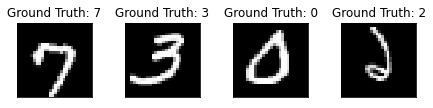

In [23]:
fig = plt.figure()
for i in range(4):
    idx_rand = random.randint(len(example_data))
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[idx_rand][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[idx_rand]))
    plt.xticks([])
    plt.yticks([])


### Build 2 CNN + 2 fully connected layer networks

In [24]:
# # Model 0
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
# #         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
        
# #         x = F.dropout(x, training=self.training)

#         x = self.fc2(x)
#         return F.log_softmax(x,-1)

In [25]:
# # Model 1
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d(p=0.2)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
# #         x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
        
#         x = F.dropout(x, training=self.training,p=0.2)

#         x = self.fc2(x)
#         return F.log_softmax(x,-1)

In [26]:
# # Model 2
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(500, 70)
#         self.fc2 = nn.Linear(70, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
# #         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
#         x = x.view(-1, 500)
#         x = F.relu(self.fc1(x))
        
# #         x = F.dropout(x, training=self.training)

#         x = self.fc2(x)
#         return F.log_softmax(x,-1)

In [27]:
# # Model 3
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 20, kernel_size=3)
#         self.conv2 = nn.Conv2d(20, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(180, 40)
#         self.fc2 = nn.Linear(40, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
# #         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 3))
    
#         x = x.view(-1, 180)
#         x = F.relu(self.fc1(x))
        
# #         x = F.dropout(x, training=self.training)

#         x = self.fc2(x)
#         return F.log_softmax(x,-1)

In [28]:
# Model 4
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        
#         x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        return F.log_softmax(x,-1)

In [29]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Train the model

In [30]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')
    
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  acc = 100. * correct / len(test_loader.dataset)
#   return acc

In [31]:
n_epochs = 1
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.2999, Accuracy: 1261/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305062
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.252363
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.206718
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.141043
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.043788
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.970242
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.617329
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.270964
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.017112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.843421
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.790580
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.481738
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.566128
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.546315
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.616195
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.453485
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.251630
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.448349
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.336291
Train Epoch: 1 [12160

In [32]:
# acc_vec = np.zeros(10)
# for i in range(0,1):   # to avoid 
#     n_epochs = 1
#     network = Net()
#     optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                           momentum=momentum)

#     train_losses = []
#     train_counter = []
#     test_losses = []
#     test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    
#     test()
#     for epoch in range(1, n_epochs + 1):
#       train(epoch)
#       acc_vec[i] = test()
# print('mean acc: ', np.mean(acc_vec))

In [33]:
print(np.mean(acc_vec[0]))
# del network

0.0


### Performance check

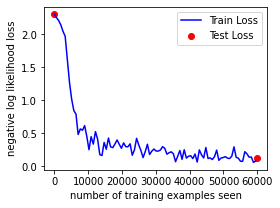

In [34]:
plt.figure(figsize = (4,3))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

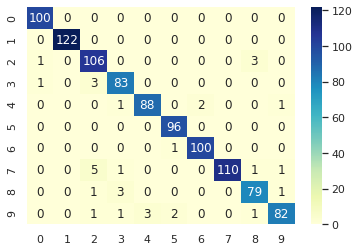

In [35]:
for data, target in test_loader:
      output = network(data)
output_idx = torch.argmax(output,dim=1)

cf_mat = confusion_matrix(target,output_idx)
sns.set(font_scale=1)
sns.heatmap(cf_mat,annot = True,cmap = 'YlGnBu', fmt='d', 
            xticklabels = np.arange(0,10), yticklabels = np.arange(0,10))

sns.reset_orig()

In [36]:
print(data.shape)
torch.unsqueeze(data[idx_rand],0).shape

torch.Size([1000, 1, 28, 28])


torch.Size([1, 1, 28, 28])

# LIME implementation on CNN prediction

### LIME Packages

In [37]:
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

### LIM classification functions

In [38]:
def batch_predict(data_array):
#     data_array = np.zeros([28,28,3])
#     data_array
#     print('see the change in dim for local variation',data_array.shape)
    network.eval()  
    data_tests = torch.Tensor(data_array[:,:,:,1]).unsqueeze(1)
#     print(data_tests.shape)
    output_tests = network(data_tests)
#     print(output_tests.shape)
    output_probs = F.softmax(output_tests,dim=1)
    
#     output_probs=torch.transpose(output_probs,0,1)
    
    return output_probs.detach().numpy()

In [ ]:
# del data_lime_array

In [ ]:
# print(network(data[idx_rand]))

### LIME

In [ ]:
# for data, target in train_loader_whole:
#       output = network(data)
# output_idx = torch.argmax(output,dim=1)

# print(data.shape)

In [ ]:
# for data, target in test_loader:
# #       output = network(data)
# # output_idx = torch.argmax(output,dim=1)
#     data_lime_array = np.array(torch.Tensor(data_test[idx_rand]).unsqueeze(0)).astype('double')
#     data_lime_array[:,np.newaxis]
#     print(data_lime_array.shape)

In [42]:
idx_rand = random.randint(len(data))

explainer = lime_image.LimeImageExplainer()


# for data_test, target_test in test_loader:
#           output = network(data)
# output_idx = torch.argmax(output,dim=1)

data_lime_array = np.zeros([28,28,3])

data_lime_array[:,:,0] = np.array(torch.Tensor(data[idx_rand]).squeeze(0)).astype('double')
data_lime_array[:,:,1] = np.array(torch.Tensor(data[idx_rand]).squeeze(0)).astype('double')
data_lime_array[:,:,2] = np.array(torch.Tensor(data[idx_rand]).squeeze(0)).astype('double')


# explanation = explainer.explain_instance(torch.Tensor(np.array(data[idx_rand]).astype('double')).unsqueeze(0), 
explanation = explainer.explain_instance(data_lime_array, 
                                         batch_predict, # classification function 
#                                          hide_color=1, 
                                         top_labels = 10,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

### Areas support/against top predictions

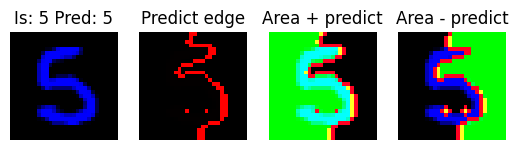

In [44]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
img_boundry1[:,:,0]=(img_boundry1[:,:,0]-np.min(img_boundry1[:,:,0]))/(np.max(img_boundry1[:,:,0])-np.min(img_boundry1[:,:,0]))
img_boundry1[:,:,2]=(img_boundry1[:,:,2]-np.min(img_boundry1[:,:,2]))/(np.max(img_boundry1[:,:,2])-np.min(img_boundry1[:,:,2]))
img_boundry1[:,:,1]=(mask-np.min(mask))/(np.max(mask)-np.min(mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[9], positive_only=True, num_features=1, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
img_boundry2[:,:,0]=(img_boundry2[:,:,0]-np.min(img_boundry2[:,:,0]))/(np.max(img_boundry2[:,:,0])-np.min(img_boundry2[:,:,0]))
img_boundry2[:,:,2]=(img_boundry2[:,:,2]-np.min(img_boundry2[:,:,2]))/(np.max(img_boundry2[:,:,2])-np.min(img_boundry2[:,:,2]))
img_boundry2[:,:,1]=(mask-np.min(mask))/(np.max(mask)-np.min(mask))

output = network(data[idx_rand].unsqueeze(0))
output_idx = torch.argmax(output,dim=1)


plt.subplot(1,4,1)
img_plot_rgb = np.zeros([28,28,3])
img_plot = np.array(data[idx_rand].squeeze(0))
img_plot_rgb[:,:,2] = (img_plot-np.min(img_plot))/(np.max(img_plot)-np.min(img_plot))
plt.imshow(img_plot_rgb)
plt.title('Is: %d Pred: %d' % (target[idx_rand], output_idx))
plt.axis('off')

plt.subplot(1,4,2)
img_boundary = np.zeros([28,28,3])
img_boundary[:,:,0] = img_boundry1[:,:,0]
plt.imshow(img_boundary)
plt.title('Predict edge')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(img_boundry1)
plt.title('Area + predict')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img_boundry2)
plt.title('Area - predict')
plt.axis('off')
        
plt.show()



##    sometimes the outputs all look the same
##    we assume this condition means that LIME did not converge thus can not give a stable important region
